The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_30558/22939737.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(10000,)
(100, 100)


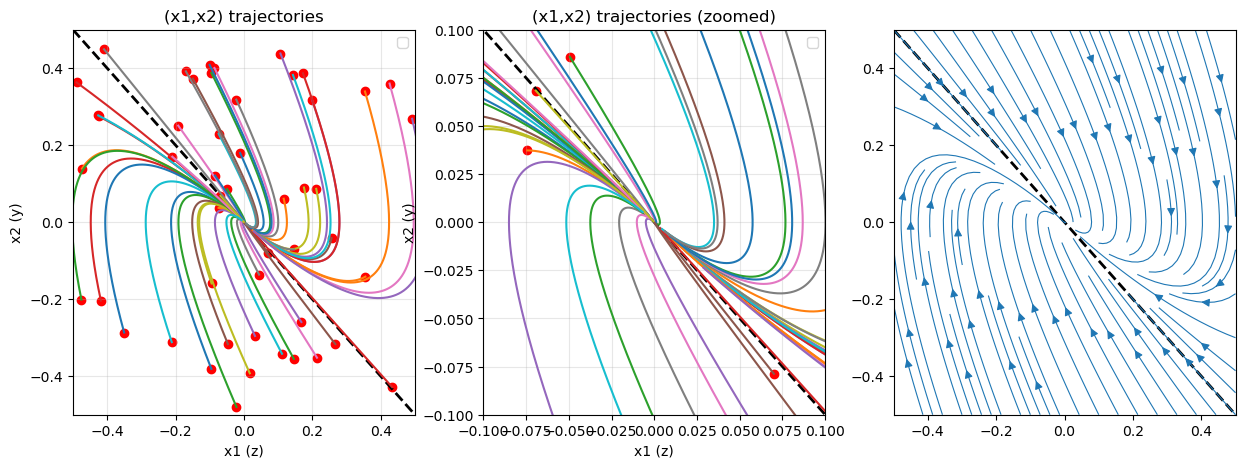

/tmp/ipykernel_30558/22939737.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_30558/22939737.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


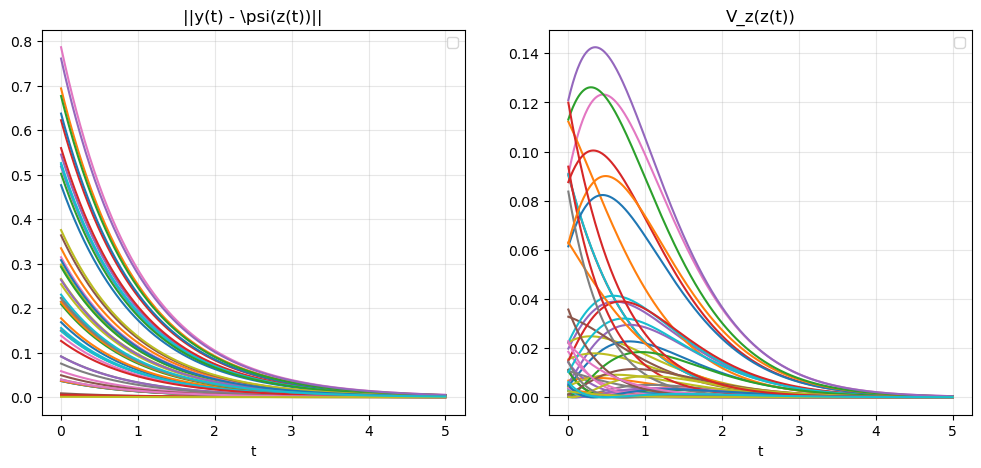

In [20]:
%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from einops import rearrange
from double_integrator import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
    rom=DoubleIntegratorROM(cfg_rom=cfg_rom)
)

ret = integrator.apply(x0s)
debug_ret = integrator.post_apply(ret)

def make_plots(ret, debug_ret):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.set_xlim(-box_width, box_width)
    ax1.set_ylim(-box_width, box_width)
    ax2.set_xlim(-0.1, 0.1)
    ax2.set_ylim(-0.1, 0.1)
    ax1.set_title('(x1,x2) trajectories')
    ax2.set_title('(x1,x2) trajectories (zoomed)')

    for ax in (ax1, ax2):
        ax.set_xlabel('x1 (z)')
        ax.set_ylabel('x2 (y)')
        ax.grid(True, alpha=0.3)
        ax.legend()

    # Zero dynamics line
    x1s = jnp.linspace(-box_width, box_width, 100)
    x2s = -cfg_rom.kpsi * x1s
    for ax in (ax1, ax2, ax3):
        ax.plot(x1s, x2s, 'k--', linewidth=2, label='Zero dynamics line')

    # rollout trajectories
    for ax in (ax1, ax2):
        for i in range(ret.xs.shape[0]):
            ax.plot(ret.xs[i, :, 0], ret.xs[i, :, 1])
            ax.scatter(ret.xs[i, 0, 0], ret.xs[i, 0, 1], color='red')
            
    # streamplot
    N = 100
    X1, X2 = jnp.meshgrid(
        jnp.linspace(-box_width, box_width, N),
        jnp.linspace(-box_width, box_width, N),
        indexing='xy'
    )
    U = X2
    V = jax.vmap(integrator.rom.policy_v, in_axes=(0, 0))(
        rearrange(X2, 'n1 n2 -> (n1 n2)'), rearrange(X1, 'n1 n2 -> (n1 n2)')
    )
    print(V.shape)
    V = rearrange(V.squeeze(), '(n1 n2) -> n1 n2', n1=N, n2=N)
    print(V.shape)
    X1n, X2n, Un, Vn = map(np.asarray, (X1, X2, U, V))
    ax3.streamplot(X1n, X2n, Un, Vn, density=1.2, linewidth=0.8, arrowsize=1.2, minlength=0.2)
            
    plt.show()

    # M_\psi error
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title(r'||y(t) - \psi(z(t))||')
    ax1.set_xlabel('t')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax2.set_title(r'V_z(z(t))')
    ax2.set_xlabel('t')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    for i in range(debug_ret.xs.shape[0]):
        ax1.plot(debug_ret.ts, debug_ret.es[i])
        ax2.plot(debug_ret.ts, debug_ret.lyaps[i])

    plt.show()

make_plots(ret, debug_ret)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1,) (50, 1)


/tmp/ipykernel_30558/22939737.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(10000, 1)
(100, 100)


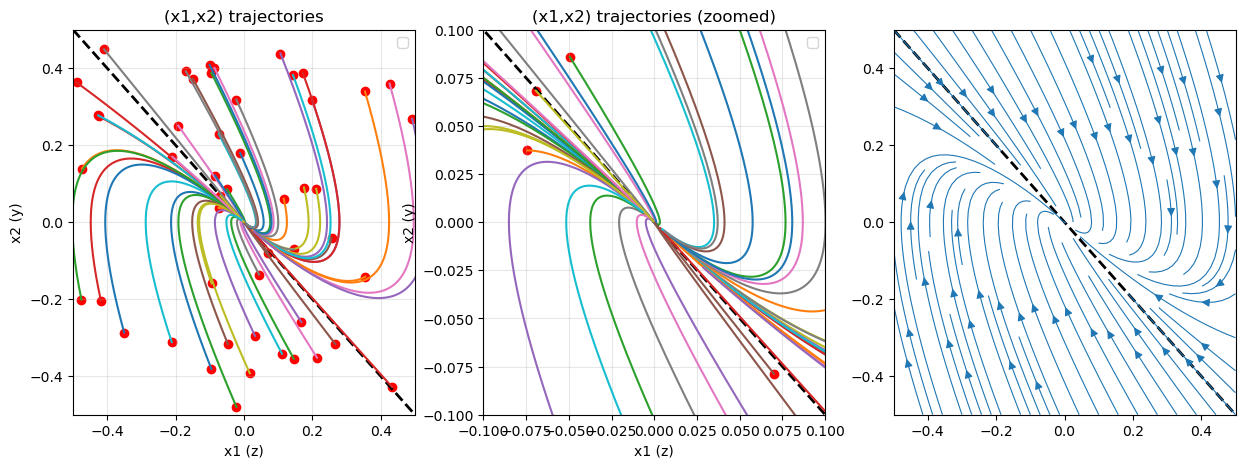

/tmp/ipykernel_30558/22939737.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_30558/22939737.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


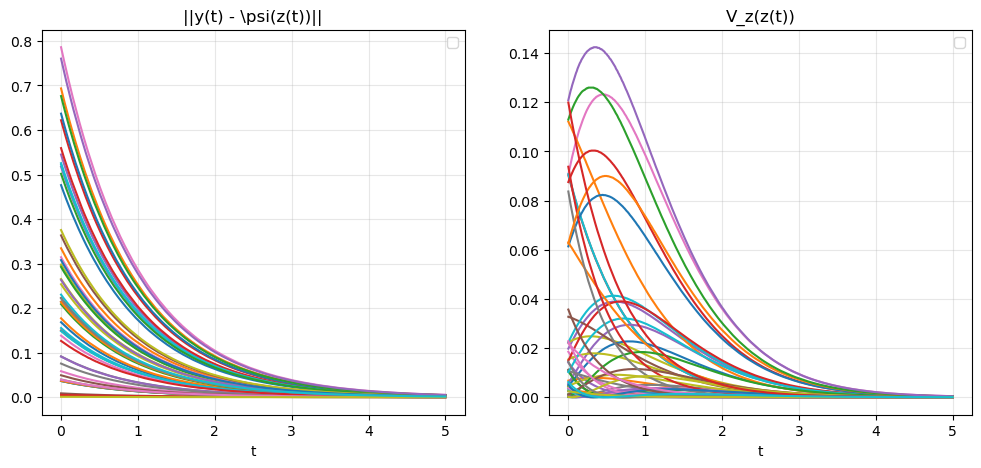

In [21]:
%load_ext autoreload
%autoreload 2


import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from double_integrator import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

rom = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom.hardcode_nn_params()

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
    rom=rom
)



ret1 = rom.policy_v(1.0, 1.0)
ret2 = jax.vmap(rom.policy_v, in_axes=(0, 0))(
    jnp.ones((50,)),
    jnp.ones((50,))
)

print(ret1.shape, ret2.shape)

ret = integrator.apply(x0s)
debug_ret = integrator.post_apply(ret)

make_plots(ret, debug_ret)